# Experiment 6
In this experiment, the adversarial learning technique is dropped altogether, a single Variational Graph-based auto-encoder is used, using the torch geometry implementation of the VGAE

VGAE proved to be inferior (to be tested) so back to experimenting with a model written from scratch

In [1]:
!ls ../../Projects/data/

 MNIST			       SWaT_Dataset_Normal_v1.xlsx
 SWaT_Dataset_Attack_v0.csv    WADI_14days_new.csv
 SWaT_Dataset_Attack_v0.xlsx  'WADI.A1_9 Oct 2017'
 SWaT_Dataset_Normal_v0.csv   'WADI.A2_19 Nov 2019'
 SWaT_Dataset_Normal_v0.xlsx   WADI_attackdataLABLE.csv
 SWaT_Dataset_Normal_v1.csv


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch_geometric.transforms as T


from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from layers import *

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
set_seed(17)

### Dataset:

In [3]:
df = pd.read_csv('../../Projects/data/SWaT_Dataset_Normal_v1.csv')
df = df.drop(columns=[' Timestamp', 'Normal/Attack'])
df = df.astype('float64')
mm = StandardScaler()
Normalized = pd.DataFrame(mm.fit_transform(df))
train_set = Normalized[: int(0.8 * Normalized.shape[0])]
validation_set = Normalized[int(0.8 * Normalized.shape[0]):]

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Dataloader:

In [5]:
window_size = 10

train_dataset = SWat_dataset(train_set, train_set, window_size, device)
validation_dataset = SWat_dataset(validation_set, validation_set, window_size, device)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

### Model:

In [6]:
class GEncoder(nn.Module):
    def __init__(self, num_nodes, window_size, alpha, k, device):
        super(GEncoder, self).__init__()
        self.num_nodes = num_nodes
        self.window_size = window_size
        self.conv1 = GCNLayer(window_size, 17)
        self.conv2 = GCNLayer(17, 40)
        self.idx = torch.arange(num_nodes).to(device)
        self.A = Graph_Directed_A(num_nodes, window_size, alpha, k, device)
        self.device = device

    def forward(self, X):
        X = torch.transpose(X, 1, 2)
        adj = self.A(self.idx)
        h = self.conv1(adj, X).relu()
        h = self.conv2(adj, h).relu()
        return h
        
        

class GCN_autoencoder(nn.Module):
    def __init__(self, encoder, num_nodes, window_size):
        super(GCN_autoencoder, self).__init__()
        self.window_size = window_size
        self.num_nodes = num_nodes
        self.encoder = encoder
        self.decoder = nn.Sequential(
            nn.Linear(2040, 1050),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(1050, num_nodes * window_size)
        )
        
    def forward(self, X):
        x = self.encoder(X)
        x = torch.flatten(x,1)
        x = self.decoder(x)
        return x.view(-1, self.window_size, self.num_nodes)

    def get_adj(self):
        return self.encoder.A(self.encoder.idx)

In [7]:
num_nodes = 51 # number of nodes
alpha = 0.20 # hyperparameter for weights of edges
k = None  # max number of edges for each node
epochs = 200

In [8]:
Encoder = GEncoder(num_nodes, window_size, alpha, k, device)
AE1 = GCN_autoencoder(Encoder, num_nodes, window_size)

In [9]:
AE1.to(device)

GCN_autoencoder(
  (encoder): GEncoder(
    (conv1): GCNLayer(
      (dense): Linear(in_features=10, out_features=17, bias=True)
    )
    (conv2): GCNLayer(
      (dense): Linear(in_features=17, out_features=40, bias=True)
    )
    (A): Graph_Directed_A(
      (e1): Embedding(51, 10)
      (e2): Embedding(51, 10)
      (l1): Linear(in_features=10, out_features=10, bias=True)
      (l2): Linear(in_features=10, out_features=10, bias=True)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=2040, out_features=1050, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1050, out_features=510, bias=True)
  )
)

In [10]:
optimizer1 = torch.optim.Adam(AE1.parameters())

In [11]:
# from torch.utils.tensorboard import SummaryWriter

In [12]:
%%time
AE1_val_history = []
for i in range(epochs):
    running_loss_AE1 = []
    val_loss_AE1 = []
    AE1.train()
    for index_b, features in enumerate(train_loader):
        
        w1 = AE1(features)
        lossAE1 = torch.mean((features - w1) ** 2)
        
        running_loss_AE1.append(lossAE1)
        lossAE1.backward()
        optimizer1.step()
        optimizer1.zero_grad()

    AE1.eval()
    for index_b, features in enumerate(validation_loader):
        with torch.no_grad():

            w1 = AE1(features)
            lossAE1 = torch.mean((features - w1) ** 2)
            val_loss_AE1.append(lossAE1)
    AE1_val_history.append(torch.stack(val_loss_AE1).mean().item())
    # writer.add_scalar('Autoendoer_1_train_loss epoch', torch.stack(running_loss_AE1).mean().item(), i + 1)
    # writer.add_scalar('Autoendoer_1_train_loss epoch', AE1_val_history[-1], i + 1)
    print(f'Epoch: {i} ---> Val loss: AE1 {AE1_val_history[-1]:.4f}')
    print(f'Train loss: AE1 {torch.stack(running_loss_AE1).mean().item():.4f}')
    if round(torch.stack(running_loss_AE1).mean().item(), 4) > 0.004:
        continue
    if round(torch.stack(running_loss_AE1).mean().item(), 4) == round(AE1_val_history[-1], 4):
        break

Epoch: 0 ---> Val loss: AE1 0.0238
Train loss: AE1 0.1314
Epoch: 1 ---> Val loss: AE1 0.0114
Train loss: AE1 0.0214
Epoch: 2 ---> Val loss: AE1 0.0090
Train loss: AE1 0.0149
Epoch: 3 ---> Val loss: AE1 0.0073
Train loss: AE1 0.0124
Epoch: 4 ---> Val loss: AE1 0.0067
Train loss: AE1 0.0108
Epoch: 5 ---> Val loss: AE1 0.0061
Train loss: AE1 0.0105
Epoch: 6 ---> Val loss: AE1 0.0056
Train loss: AE1 0.0091
Epoch: 7 ---> Val loss: AE1 0.0059
Train loss: AE1 0.0087
Epoch: 8 ---> Val loss: AE1 0.0049
Train loss: AE1 0.0083
Epoch: 9 ---> Val loss: AE1 0.0047
Train loss: AE1 0.0080
Epoch: 10 ---> Val loss: AE1 0.0049
Train loss: AE1 0.0076
Epoch: 11 ---> Val loss: AE1 0.0043
Train loss: AE1 0.0074
Epoch: 12 ---> Val loss: AE1 0.0042
Train loss: AE1 0.0074
Epoch: 13 ---> Val loss: AE1 0.0040
Train loss: AE1 0.0070
Epoch: 14 ---> Val loss: AE1 0.0038
Train loss: AE1 0.0067
Epoch: 15 ---> Val loss: AE1 0.0040
Train loss: AE1 0.0066
Epoch: 16 ---> Val loss: AE1 0.0036
Train loss: AE1 0.0066
Epoch: 

KeyboardInterrupt: 

# Testing

In [13]:
df2 = pd.read_csv('../../Projects/data/SWaT_Dataset_Attack_v0.csv')
labels = df2['Normal/Attack']
df2 = df2.drop(columns=[' Timestamp', 'Normal/Attack'])
df2 = df2.astype('float64')
df2.columns = df.columns
test_normalized = pd.DataFrame(mm.transform(df2))

In [14]:
test_dataset = SWat_dataset(test_normalized, test_normalized, window_size, device)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [15]:
def testing(test_loader, alpha=.5, beta=.5):
    results=[]
    AE1.eval()
    with torch.no_grad():
        for batch in test_loader:
            w1=AE1(batch)
            results.append(torch.mean(torch.mean((batch-w1)**2, axis=1), axis=1))
    return results

In [16]:
labels = labels.values
labels = [0 if (lab == 'Normal') else 1 for lab in labels]
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int32(labels[i:i+window_size])))

In [17]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels]

In [18]:
results=testing(test_loader, alpha=0.3, beta=0.7)

In [19]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

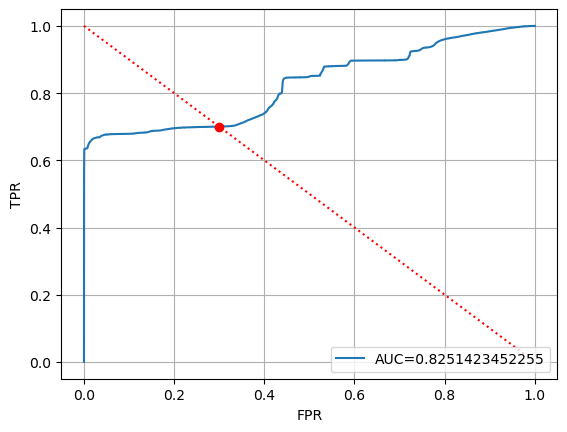

array([0.74987423], dtype=float32)

In [20]:
threshold = ROC(y_test,y_pred)
threshold

best: 1.9764705882352942 F1: 0.7728085470275313


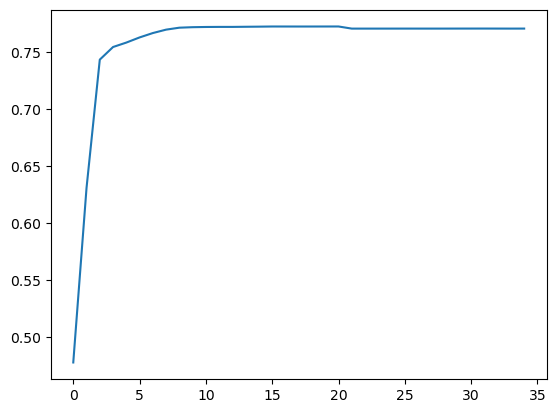

In [21]:
ff = 0
f_history = []
initial_y = 0.8
best = -1
for inc in np.linspace(0, 2, 35):
    y_pred_int = [1 if (yy > initial_y + inc) else 0 for yy in y_pred]
    conf_matrix = confusion_matrix(y_test, y_pred_int)
    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    F1 = f1_score(y_test, y_pred_int)
    f_history.append(F1)

    precision = precision_score(y_test, y_pred_int)
    recall = recall_score(y_test, y_pred_int)
    if F1 > ff:
        ff = F1
        best = inc
print(f'best: {best + initial_y} F1: {ff}')
plt.plot(f_history)

In [22]:
torch.save(AE1.state_dict(), 'GAE_77_Directed_200_epochs.pth')

In [23]:
AE1.load_state_dict(torch.load('GAE_77_Directed_200_epochs.pth'))

<All keys matched successfully>